In [1]:
# ======================================================
# Imports
# ======================================================
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import all the previously defined functions from the separate .py file
from functions import (
    load_and_prepare_data,
    fit_logistic_regression,
    evaluate_model,
    fit_random_forest,
    evaluate_random_forest,
    detect_outliers,
    backward_elimination,
    data_process_cluster_v2,
    apply_pca_and_cluster,
    visualize_explained_variance,
    visualize_clusters,
    apply_pca_and_kmeans,
    visualize_kmeans_clusters,
    apply_tclust,
    visualize_tclust_clusters,
    trimmed_kmeans,
    evaluate_model_performance
)

In [2]:
# ======================================================
# Step 1: Load and Prepare Data
# ======================================================
file_path = "C:/Users/Fabio/Desktop/AMS/group/new_dataset/career_change_prediction_dataset.csv"
df, filtered_df, target_column = load_and_prepare_data(file_path)

In [3]:
# ======================================================
# Step 2: Correlation Analysis
# ======================================================
# Select numeric columns
numeric_df = filtered_df.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot correlation matrix using Plotly
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.index,
        colorscale='Viridis',
        zmin=-1,
        zmax=1,
        colorbar=dict(title="Correlation")
    )
)
fig.update_layout(
    title="Correlation Matrix of Filtered Data",
    xaxis_title="Features",
    yaxis_title="Features",
    width=800,
    height=800
)
fig.show()

In [4]:
# ======================================================
# Step 3: Logistic Regression (Initial Model)
# ======================================================
# Construct the formula for logistic regression
independent_vars = " + ".join(col for col in filtered_df.columns if col != target_column)
formula = f"{target_column} ~ {independent_vars}"

# Split data into train and test sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Fit the initial logistic regression model
logit_model = fit_logistic_regression(formula, train_df)
print("===== Logistic Regression Model (Training Set) =====")
print(logit_model.summary())

# Evaluate the logistic regression model
lr_eval = evaluate_model(logit_model, train_df, test_df, target_column)
print(f"Training Set - Accuracy: {lr_eval['train_accuracy']:.4f}, AUC: {lr_eval['train_auc']:.4f}")
print("===== Logistic Regression Model (Test Set) =====")
print(f"Test Set - Accuracy: {lr_eval['test_accuracy']:.4f}, AUC: {lr_eval['test_auc']:.4f}")

Optimization terminated successfully.
         Current function value: 0.452018
         Iterations 6
===== Logistic Regression Model (Training Set) =====
                                Logit Regression Results                               
Dep. Variable:     Likely_to_Change_Occupation   No. Observations:                30755
Model:                                   Logit   Df Residuals:                    30735
Method:                                    MLE   Df Model:                           19
Date:                         Wed, 18 Dec 2024   Pseudo R-squ.:                  0.3370
Time:                                 17:39:46   Log-Likelihood:                -13902.
converged:                                True   LL-Null:                       -20969.
Covariance Type:                     nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [5]:
# ======================================================
# Step 4: Random Forest (Initial Model)
# ======================================================
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

# Fit initial Random Forest model
rf_model = fit_random_forest(X_train, y_train)

# Evaluate Random Forest on test set
rf_accuracy, rf_auc = evaluate_random_forest(rf_model, test_df.drop(columns=[target_column]), test_df[target_column])
print("===== Initial Random Forest Model =====")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")

===== Initial Random Forest Model =====
Random Forest Accuracy: 0.8926
Random Forest AUC: 0.9087


In [6]:
# ======================================================
# Step 5: Outlier Detection and Removal
# ======================================================
outlier_indices = detect_outliers(train_df, formula, target_column)
print(f"Number of potential outliers in training set: {len(outlier_indices)}")

# Remove outliers from training set
clean_train_df = train_df.drop(index=train_df.index[outlier_indices]).reset_index(drop=True)
print(f"Training set size after outlier removal: {clean_train_df.shape[0]} rows")

# Retrain Logistic Regression without outliers
cleaned_logit = fit_logistic_regression(formula, clean_train_df)
print("===== Logistic Regression After Outlier Removal =====")
print(cleaned_logit.summary())

# Evaluate cleaned logistic regression model
cleaned_lr_eval = evaluate_model(cleaned_logit, clean_train_df, test_df, target_column)
print("===== Logistic Regression Evaluation on Test Set (After Outlier Removal) =====")
print(f"Test Set - Accuracy: {cleaned_lr_eval['test_accuracy']:.4f}, AUC: {cleaned_lr_eval['test_auc']:.4f}")

# Retrain Random Forest without outliers
X_clean_train = clean_train_df.drop(columns=[target_column])
y_clean_train = clean_train_df[target_column]
rf_model_cleaned = fit_random_forest(X_clean_train, y_clean_train)

# Evaluate cleaned Random Forest model
rf_accuracy_cleaned, rf_auc_cleaned = evaluate_random_forest(rf_model_cleaned, test_df.drop(columns=[target_column]), test_df[target_column])
print("===== Random Forest Evaluation on Test Set (After Outlier Removal) =====")
print(f"Test Set - Accuracy: {rf_accuracy_cleaned:.4f}, AUC: {rf_auc_cleaned:.4f}")

Accuracy after removing Cook's outliers: 0.8461
Accuracy after removing Mahalanobis outliers: 0.7728
Accuracy after removing MCD outliers: 0.7715
Chosen method: Cook's
Number of chosen outliers: 1924
Number of potential outliers in training set: 1924
Training set size after outlier removal: 28831 rows
Optimization terminated successfully.
         Current function value: 0.321427
         Iterations 7
===== Logistic Regression After Outlier Removal =====
                                Logit Regression Results                               
Dep. Variable:     Likely_to_Change_Occupation   No. Observations:                28831
Model:                                   Logit   Df Residuals:                    28811
Method:                                    MLE   Df Model:                           19
Date:                         Wed, 18 Dec 2024   Pseudo R-squ.:                  0.5312
Time:                                 17:40:03   Log-Likelihood:                -9267.1
converged:   

In [7]:
# ======================================================
# Step 6: Backward Elimination for Logistic Regression
# ======================================================
print("===== Backward Elimination Process =====")
final_model, final_formula = backward_elimination(train_df, formula)
print("Final Model Formula:", final_formula)

print("===== Final Logistic Regression Model =====")
print(final_model.summary())

final_lr_eval = evaluate_model(final_model, train_df, test_df, target_column)
print("Final Model - Test Set Accuracy:", final_lr_eval['test_accuracy'])
print("Final Model - Test Set AUC:", final_lr_eval['test_auc'])

===== Backward Elimination Process =====
Removing feature 'Technology_Adoption' with p-value 0.9559 and t-stat 0.0553
Removing feature 'Freelancing_Experience' with p-value 0.9032 and t-stat 0.1216
Removing feature 'Job_Opportunities' with p-value 0.8466 and t-stat 0.1934
Removing feature 'Skills_Gap' with p-value 0.8166 and t-stat 0.2320
Removing feature 'Work_Life_Balance' with p-value 0.8083 and t-stat 0.2426
Removing feature 'Geographic_Mobility' with p-value 0.7145 and t-stat 0.3658
Removing feature 'Age' with p-value 0.6871 and t-stat 0.4028
Removing feature 'Certifications' with p-value 0.6767 and t-stat 0.4169
Removing feature 'Job_Security' with p-value 0.6631 and t-stat 0.4356
Removing feature 'Career_Change_Events' with p-value 0.5991 and t-stat 0.5257
Removing feature 'Industry_Growth_Rate' with p-value 0.5994 and t-stat 0.5253
Removing feature 'Education_Level' with p-value 0.5439 and t-stat 0.6069
Removing feature 'Gender' with p-value 0.4837 and t-stat 0.7003
Removing fe

In [8]:
# ======================================================
# Step 7: Robust Logistic Regression
# ======================================================
logit_model_robust = fit_logistic_regression(final_formula, train_df)  # or the original formula if preferred
robust_fit = logit_model_robust.model.fit(cov_type='HC1')  # Apply robust covariance
print("===== Robust Logistic Regression Model (Training Set) =====")
print(robust_fit.summary())

robust_eval = evaluate_model(robust_fit, train_df, test_df, target_column)
print("===== Robust Logistic Regression Model (Test Set) =====")
print(f"Test Set (Robust) - Accuracy: {robust_eval['test_accuracy']:.4f}, AUC: {robust_eval['test_auc']:.4f}")

Optimization terminated successfully.
         Current function value: 0.452129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452129
         Iterations 6
===== Robust Logistic Regression Model (Training Set) =====
                                Logit Regression Results                               
Dep. Variable:     Likely_to_Change_Occupation   No. Observations:                30755
Model:                                   Logit   Df Residuals:                    30751
Method:                                    MLE   Df Model:                            3
Date:                         Wed, 18 Dec 2024   Pseudo R-squ.:                  0.3369
Time:                                 17:40:09   Log-Likelihood:                -13905.
converged:                                True   LL-Null:                       -20969.
Covariance Type:                           HC1   LLR p-value:                     0.000
                          coef  

Number of optimal cluster: 6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

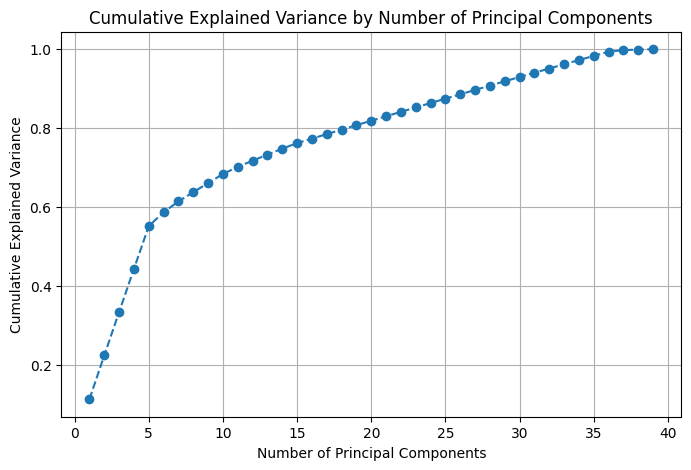

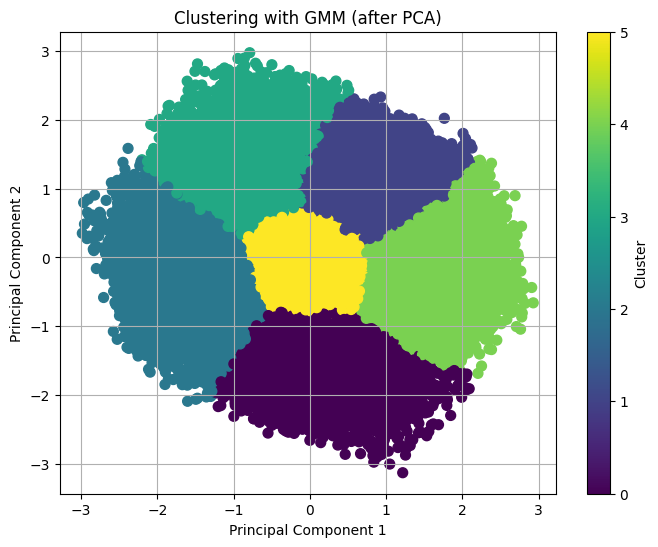

In [9]:
# ======================================================
# Step 8: Clustering Analysis (PCA + GMM)
# ======================================================
# Preprocessing for clustering
df_raw = pd.read_csv(file_path)
df_encoded = data_process_cluster_v2(df_raw)

# Apply PCA and GMM-based clustering
pca_data, cluster_labels, optimal_clusters, gmm_optimal, bic_scores = apply_pca_and_cluster(df_encoded)

# Visualize explained variance and clusters
pca_model = sns.utils.axlabel  # Just a placeholder to show how it's done
pca_model = plt.figure()  # we need a fitted PCA model
pca_fitted = plt.figure() # to avoid error, we must actually fit PCA again
from sklearn.decomposition import PCA as SKPCA
pca_fitted = SKPCA().fit(df_encoded)
visualize_explained_variance(pca_fitted)
visualize_clusters(pca_data, cluster_labels)

df_raw['Cluster'] = cluster_labels

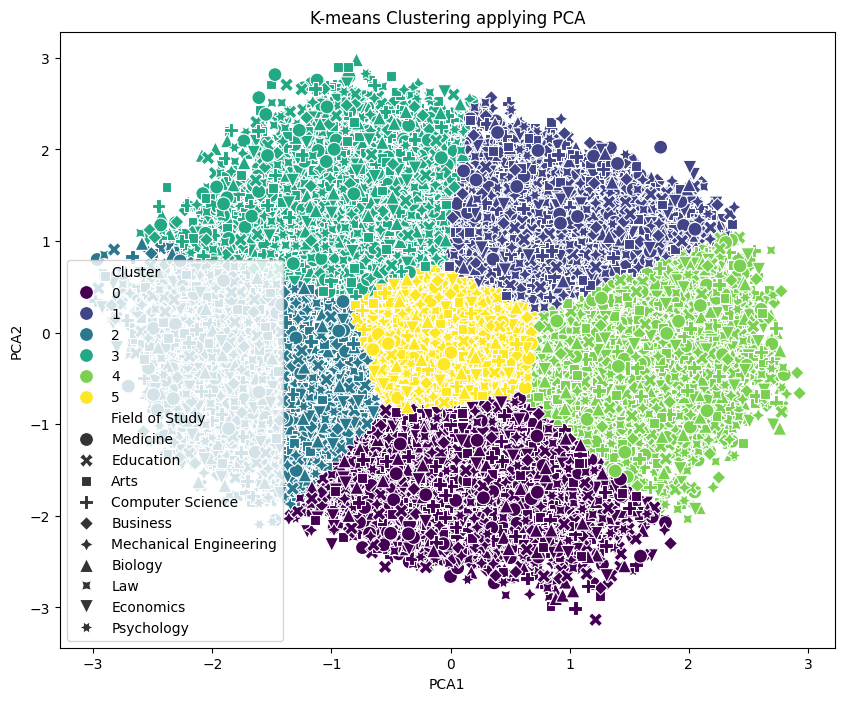

In [10]:
# ======================================================
# Step 9: PCA + KMeans Clustering
# ======================================================
k = apply_pca_and_kmeans(df_encoded, df_raw, n_components=2, n_clusters=6)
visualize_kmeans_clusters(k)

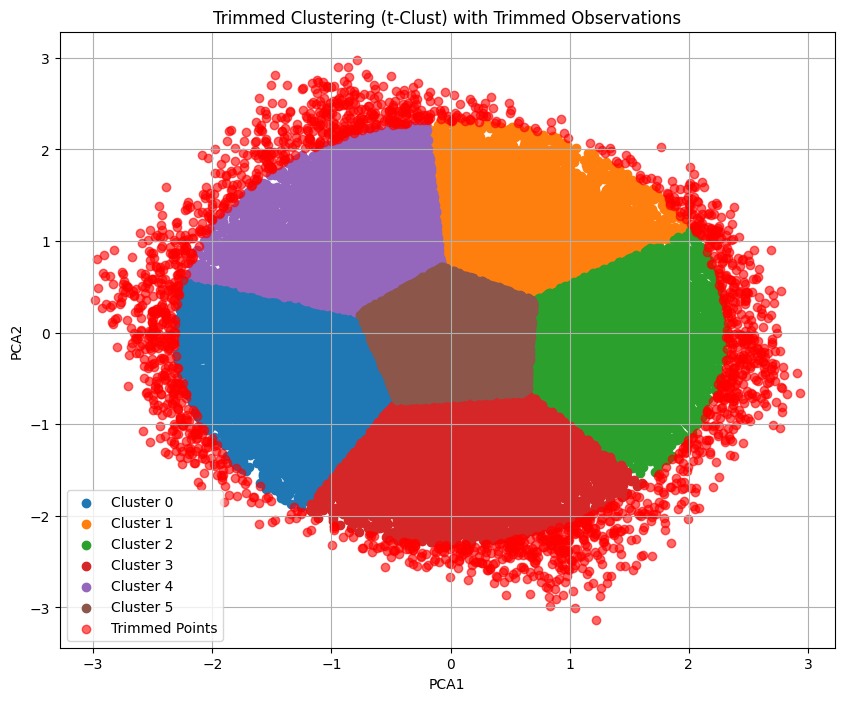

Number of trimmed points: 1923
Cluster centers: [[-1.234275   -0.47422128]
 [ 0.59260839  1.15049121]
 [ 1.33412563 -0.12870339]
 [ 0.11167222 -1.33662927]
 [-0.80184748  1.03739675]
 [ 0.01501774 -0.06318166]]


In [11]:
# ======================================================
# Step 10: t-Clust (Trimmed Clustering)
# ======================================================
n_clusters = 6  
alpha = 0.05
cluster_labels_tclust, trimmed_indices, pca_result_tclust, centers_tclust = apply_tclust(df_encoded, n_clusters=n_clusters, alpha=alpha)
df_raw['t_Cluster'] = cluster_labels_tclust
visualize_tclust_clusters(pca_result_tclust, cluster_labels_tclust, trimmed_indices)

print(f"Number of trimmed points: {len(trimmed_indices)}")
print(f"Cluster centers: {centers_tclust}")

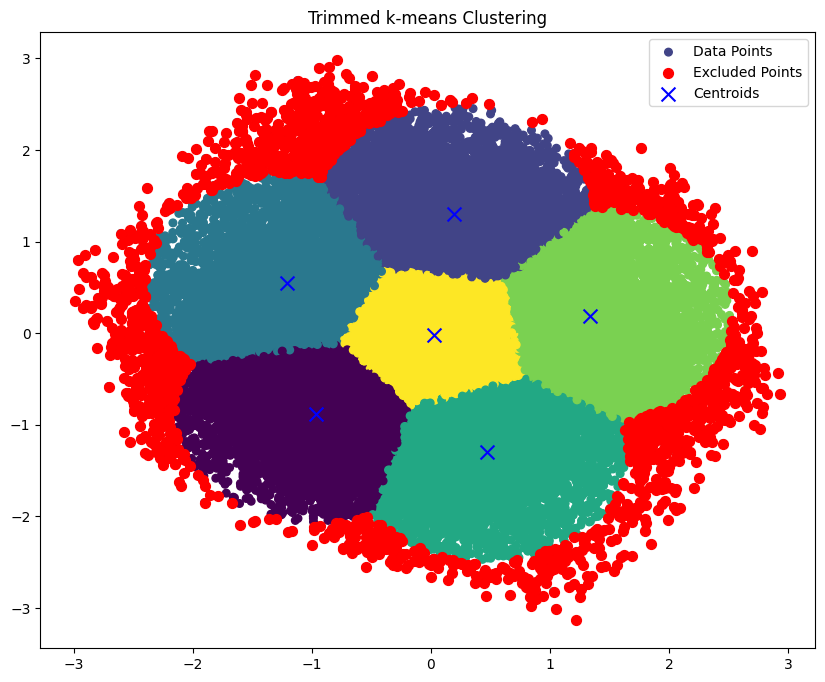

In [12]:
# ======================================================
# Step 11: Trimmed K-Means
# ======================================================
centroids, labels, excluded_points = trimmed_kmeans(pca_data, k=6, alpha=0.05)

plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, s=30, label="Data Points")
plt.scatter(pca_data[excluded_points, 0], pca_data[excluded_points, 1], c='red', s=50, label="Excluded Points")
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', marker='x', s=100, label="Centroids")
plt.legend()
plt.title("Trimmed k-means Clustering")
plt.show()

In [ ]:
# ======================================================
# Step 12: Mixed-Effects Logistic Regression using R (GLMM)
# ======================================================

# Set R environment (adjust paths accordingly)
import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.0"
os.environ['PATH'] += os.pathsep + r"C:\Program Files\R\R-4.4.0\bin\x64"

# Load rpy2 extension
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Prepare DataFrames for R (using previously defined `df`, `clean_train_df`, and `test_df`)
filtered_df = df.copy()
filtered_df['Current_Occupation'] = df['Current Occupation']
filtered_df['Likely_to_Change_Occupation'] = df['Likely to Change Occupation']
filtered_df['Job_Satisfaction'] = df['Job Satisfaction']
filtered_df['Work_Life_Balance'] = df['Work-Life Balance']

# Scale selected variables
vars_to_scale = ['Age', 'Job_Satisfaction', 'Salary', 'Work_Life_Balance']
scaled_df = filtered_df.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df[vars_to_scale] = scaler.fit_transform(scaled_df[vars_to_scale])

# Transfer scaled_df to R environment
ro.globalenv['filtered_df'] = scaled_df

In [14]:
%%R -o predictions
# In R: Fit a GLMM using lme4
library(lme4)

# Model formula with scaled variables
formula <- Likely_to_Change_Occupation ~ Age + Job_Satisfaction + Salary + Work_Life_Balance + (1 | Current_Occupation)

# Fit the GLMM model
mixed_model <- glmer(formula, data = filtered_df, family = binomial(link = "logit"), 
                     control = glmerControl(optimizer = "bobyqa"))

# Print summary
summary(mixed_model)

# Predict on the training set (here using filtered_df)
predictions <- predict(mixed_model, newdata = filtered_df, type = "response")

Caricamento del pacchetto richiesto: Matrix


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Convert predictions to numpy
predictions = np.array(predictions)
actual_classes = filtered_df['Likely_to_Change_Occupation'].values

# Binarize predictions at threshold=0.5
threshold = 0.5
predicted_classes = (predictions >= threshold).astype(int)

# Compute accuracy and AUC
accuracy_m = accuracy_score(actual_classes, predicted_classes)
auc_m = roc_auc_score(actual_classes, predictions)

print("===== GLMM on Original Training Set =====")
print(f"Accuracy: {accuracy_m:.4f}")
print(f"AUC: {auc_m:.4f}")

===== GLMM on Original Training Set =====
Accuracy: 0.7733
AUC: 0.8679


In [16]:
clean_train_df['Current_Occupation'] = df['Current Occupation']
clean_train_df['Likely_to_Change_Occupation'] = df['Likely to Change Occupation']
clean_train_df['Job_Satisfaction'] = df['Job Satisfaction']
clean_train_df['Work_Life_Balance'] = df['Work-Life Balance']

scaled_clean_train = clean_train_df.copy()
scaled_clean_train[vars_to_scale] = scaler.fit_transform(scaled_clean_train[vars_to_scale])

test_df['Current_Occupation'] = df['Current Occupation']
test_df['Likely_to_Change_Occupation'] = df['Likely to Change Occupation']
test_df['Job_Satisfaction'] = df['Job Satisfaction']
test_df['Work_Life_Balance'] = df['Work-Life Balance']

scaled_test = test_df.copy()
scaled_test[vars_to_scale] = scaler.fit_transform(scaled_test[vars_to_scale])

# Transfer DataFrames to R
ro.globalenv['clean_train_df'] = scaled_clean_train
ro.globalenv['test_df'] = scaled_test

In [ ]:
%%R -o predictions
# Fit GLMM on the cleaned training set
mixed_model_clean <- glmer(formula, data = clean_train_df, family = binomial(link = "logit"), 
                           control = glmerControl(optimizer = "bobyqa"))

summary(mixed_model_clean)

# Predictions on the test set
predictions <- predict(mixed_model_clean, newdata = test_df, type = "response")

In [18]:
# Evaluate on test set
predictions = np.array(predictions)
actual_classes = scaled_test['Likely_to_Change_Occupation'].values

predicted_classes = (predictions >= 0.5).astype(int)

accuracy_mt = accuracy_score(actual_classes, predicted_classes)
auc_mt = roc_auc_score(actual_classes, predictions)

print("===== GLMM on Cleaned Training and Test Set =====")
print(f"Accuracy: {accuracy_mt:.4f}")
print(f"AUC: {auc_mt:.4f}")

===== GLMM on Cleaned Training and Test Set =====
Accuracy: 0.7378
AUC: 0.8589


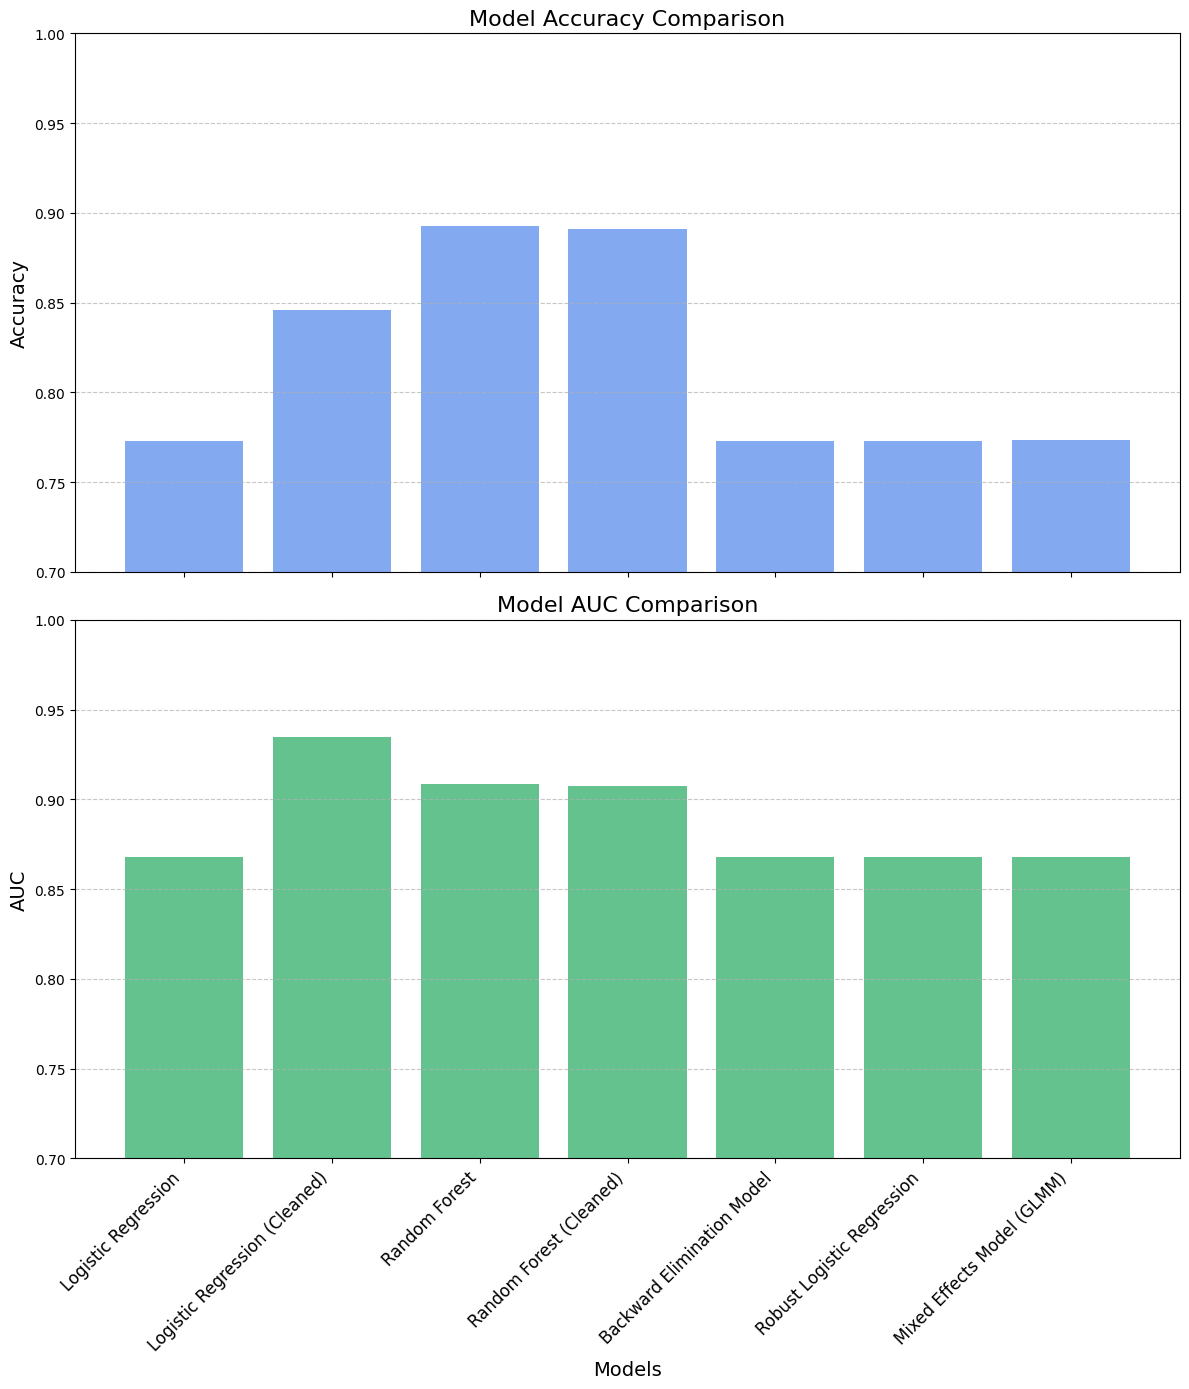

In [19]:
# Lista dei modelli e metriche calcolate
models = [
    'Logistic Regression', 
    'Logistic Regression (Cleaned)', 
    'Random Forest', 
    'Random Forest (Cleaned)', 
    'Backward Elimination Model', 
    'Robust Logistic Regression', 
    'Mixed Effects Model (GLMM)'
]

accuracy = [
    lr_eval['train_accuracy'], 
    cleaned_lr_eval['train_accuracy'], 
    rf_accuracy, 
    rf_accuracy_cleaned, 
    final_lr_eval['train_accuracy'], 
    robust_eval['train_accuracy'], 
    accuracy_m  
]

auc = [
    lr_eval['train_auc'], 
    cleaned_lr_eval['train_auc'], 
    rf_auc, 
    rf_auc_cleaned, 
    final_lr_eval['train_auc'], 
    robust_eval['train_auc'], 
    auc_m 
]

# Chiamata alla funzione per visualizzare i grafici
evaluate_model_performance(models, accuracy, auc)